In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import matplotlib.ticker

def extrapolate_rainfall (fp,value,extrapolate=False):
    hour_log_value = np.log10(60)
    day_log_value = np.log10(1440)
    log_15 = np.log10(value)
    xp = [hour_log_value, day_log_value]
    interprob = np.interp(hour_log_value, xp, fp)
    if extrapolate:
      f = interpolate.interp1d(xp, fp, fill_value = "extrapolate")
    else:
      f = interpolate.interp1d(xp, fp)
    return np.power(10,f(log_15))

def get_rain_prob_table(dataframe , column_name, hour):
    rain_df = dataframe[column_name].sort_values(ascending = False)
    new_index = list(range(1,rain_df.shape[0]+1))
    mean = np.mean(dataframe[column_name])
    std_dev = np.std(dataframe[column_name])
    cv = std_dev / mean
    rain_df = pd.DataFrame({column_name :rain_df,'Year' : rain_df.index})
    rain_df['index'] = new_index
    rain_df = rain_df.set_index('index')
    rain_df['Log(Rain)'] = rain_df[column_name].apply(lambda x: np.log10(x))
    rain_df['CF Probability'] = [(x/len(rain_df))*100 for x in new_index ]
    rain_df['CF Return'] = 1/(rain_df['CF Probability']/100)
    rain_df['CF Log(R.L)'] = rain_df['CF Return'].apply(lambda x: np.log10(x))
    rain_df['Weibull Probability'] = [(x/(len(rain_df)+1))*100 for x in new_index ]
    rain_df['Weibull Return'] = 1/(rain_df['Weibull Probability']/100)
    rain_df['Weibull y-Function'] = rain_df['Weibull Return'].apply(lambda x: -1*np.log(np.log(x/(x-1))))
    rain_df['L-Moment Estimation'] = ((len(rain_df) - rain_df.index)/(len(rain_df)*(len(rain_df)-1)))
    rain_df['L-Moment Estimation'] = rain_df['L-Moment Estimation']*rain_df[column_name]
    epsilon = 0.577
    beta_0 = mean
    beta_1 = np.sum(rain_df['L-Moment Estimation'])
    lambda_1 = mean
    lambda_2 = 2*beta_1-beta_0
    tau_2 = lambda_2 / lambda_1
    sigma = mean * tau_2
    a_hat = np.sqrt(6)*sigma / np.pi
    m_hat = mean - epsilon*a_hat
    return get_probability_table(m_hat,a_hat,hour)

def get_probability_table(m_hat,a_hat,hour):
    probability_table = pd.DataFrame({'Selected Return Interval' :[2,5,10,15,20,25,50,75,100]})
    probability_table['Probability'] = 100/probability_table['Selected Return Interval']
    probability_table['LMR (Inches)'] = m_hat - a_hat*np.log(-1*np.log(1-probability_table['Probability']/100))
    probability_table['LMR (mm)'] = probability_table['LMR (Inches)']*25.4
    probability_table['LMR (mm/hr)'] = probability_table['LMR (Inches)']*25.4 / hour
    probability_table['Log(LMR (mm/hr))'] = np.log10(probability_table['LMR (mm/hr)'])
    return probability_table
    

def get_rain_series(rain_dataFrame, hours):
    series_all = []
    for i in range (hours,len(rain_dataFrame)):
        series = rain_dataFrame.iloc[(i-hours):i,0]
        series_all.append(np.sum(series))
    return series_all

def CreatePlot(plt, log_graph):
  plt.xlim(10,1500)
  plt.ylim(1,400)
  if log_graph:
      plt.xlim(10,2000)
      plt.ylim(1,1000)
      plt.xscale('log',basex=10) 
      plt.yscale('log',basey=10) 
  plt.grid(True,which="both",ls="-")
  plt.xlabel("DURATION (MINUTES)")
  plt.ylabel("INTENSITY (MM/HOUR)")
  plt.legend(loc=1)
  plt.title("IDF Curve")
  plt.show()
  
  
def plot_probablity_table(max_rain_df, log_graph = False):
    probability_table_1 = get_rain_prob_table(max_rain_df, '1 HR (IN)', 1)
    probability_table_2 = get_rain_prob_table(max_rain_df, '2 HR (IN)', 2)
    probability_table_4 = get_rain_prob_table(max_rain_df, '4 HR (IN)',4)
    probability_table_12 = get_rain_prob_table(max_rain_df, '12 HR (IN)',12)
    probability_table = get_rain_prob_table(max_rain_df, '24 HR (IN)',24)
    graph_legend = ['2-yr','5-yr','10-yr','15-yr','20-yr','25-yr','50-yr','75-yr','100-yr']

    plt.figure(figsize=(12,8))

    for i in range(len(probability_table)):
        fp = [probability_table_1.iloc[i,5],probability_table.iloc[i,5]]
        mm_hr_15 = extrapolate_rainfall(fp,15,True)
        legend = graph_legend[i]
        y2 = probability_table_1.iloc[i,4]
        y3 = probability_table_2.iloc[i,4]
        y4 = probability_table_4.iloc[i,4]
        y5 = probability_table_12.iloc[i,4]
        y6 = probability_table.iloc[i,4]
        graph_df = pd.DataFrame({'Duration mins':[15,60,120,180,720,1440],legend:[mm_hr_15,y2,y3,y4,y5,y6]})
        plt.plot(graph_df['Duration mins'],graph_df[legend])
        
    CreatePlot(plt,log_graph)

rain_db = pd.read_csv('https://www.dropbox.com/s/ygm92ss36sjeh9a/rain_3.csv?raw=1')

rain_db.fillna(0, inplace = True)

years = range(1800,2015)

columns = ['1 HR (MM)','2 HR (MM)','4 HR (MM)','12 HR (MM)','24 HR (MM)','1 HR (IN)','2 HR (IN)','4 HR (IN)','12 HR (IN)','24 HR (IN)']

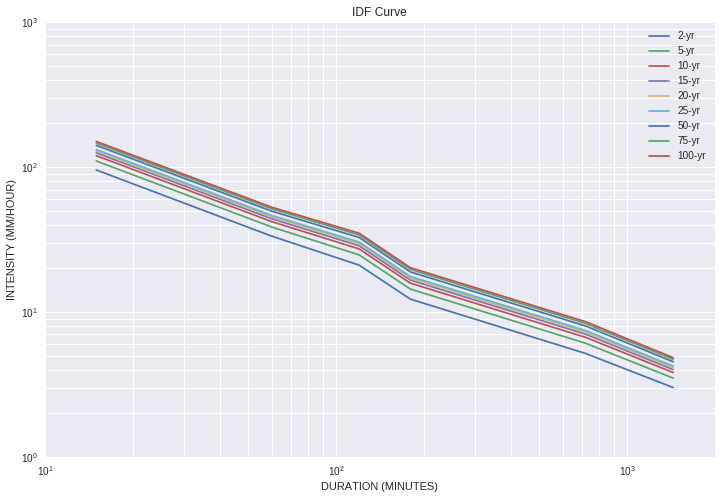

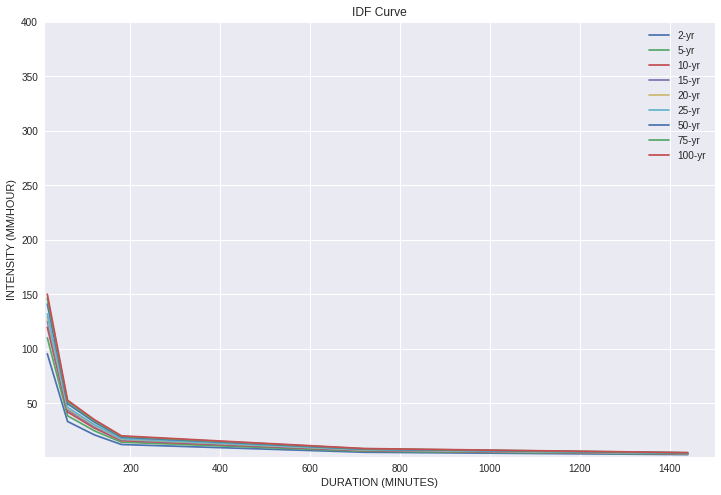

In [17]:


max_rain_df = pd.DataFrame(index = years,columns = columns)

for year in years:
    rain = rain_db[rain_db['YEAR'] == year]
    rain = rain.drop(['INDEX', 'YEAR', 'MONTH', 'DATE','TOTRF', 'HRMAX', 'H1', 'H2', 'HR', 'MI'],axis=1)

    max_rain_df['1 HR (MM)'][year] = np.max(np.max(rain))#np.amax
    max_rain_df['1 HR (IN)'][year] = np.max(np.max(rain)) / 25.4
   
    if not rain.empty:
        rows = rain.values.flatten()
        columns =['Every Hour']
        rain_1980_24 = pd.DataFrame(rows, columns=columns)
        
        series_all = get_rain_series(rain_1980_24, 24)
        
        max_rain_df['24 HR (MM)'][year] = np.max(series_all)
        max_rain_df['24 HR (IN)'][year] = np.max(series_all) / 25.4
        
        series_all = get_rain_series(rain_1980_24, 2)
        max_rain_df['2 HR (MM)'][year] = np.max(series_all)
        max_rain_df['2 HR (IN)'][year] = np.max(series_all) / 25.4
        
        series_all = get_rain_series(rain_1980_24, 12)
        max_rain_df['12 HR (MM)'][year] = np.max(series_all)
        max_rain_df['12 HR (IN)'][year] = np.max(series_all) / 25.4
        
        series_all = get_rain_series(rain_1980_24, 4)
        max_rain_df['4 HR (MM)'][year] = np.max(series_all)
        max_rain_df['4 HR (IN)'][year] = np.max(series_all) / 25.4
        
max_rain_df = max_rain_df.dropna(how='any')

plot_probablity_table(max_rain_df,True)

plot_probablity_table(max_rain_df)
